In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-26 20:16:00.428110: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
L_vars = 23

In [6]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead21.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead21.npy"))

In [7]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead21.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead21.npy"))

In [28]:
filename_valid = filename_neg_valid + filename_pos_valid

In [29]:
len(filename_valid)

330620

In [30]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

In [32]:
L_valid = len(filename_valid)
L_var = 23

TEST_input = np.empty((L_valid, 64, 64, L_var))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
   
    TEST_input[i, ...] = data

    if 'pos' in name:
        TEST_target[i] = 1.0
    else:
        TEST_target[i] = 0.0

In [33]:
np.sum(TEST_target) / len(TEST_target)

0.0033270824511523805

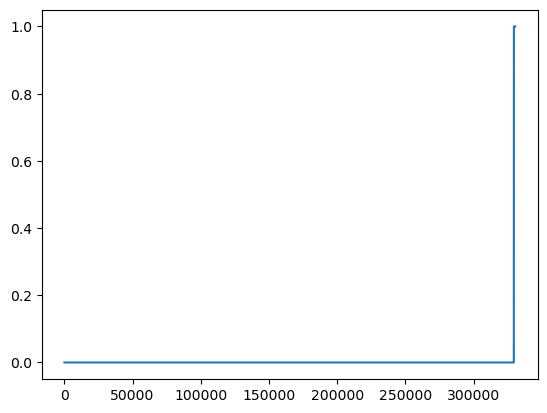

In [34]:
plt.plot(TEST_target)

**ConvNext**

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [36]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6
model_name='test'
input_shape=(64, 64, 23)
classes=1

IN = layers.Input(shape=input_shape)
X = IN

num_convnext_blocks = 4

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

OUT = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT)
OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN, outputs=OUT, name=model_name)

In [37]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss


def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [38]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [39]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'FINAL_HALF_Lead21'

model_name = '{}_pp23_tune'.format(key)
model_path = temp_dir+model_name

model_name_backup = '{}_pp23_backup'.format(key)
model_path_backup = temp_dir+model_name_backup
W_old = k_utils.dummy_loader(temp_dir+'FINAL_HALF_Lead21_pp23')
model.set_weights(W_old)


In [40]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-5))
#keras.losses.BinaryCrossentropy(from_logits=True)

In [41]:
X_batch = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [42]:
Y_pred = model.predict([TEST_input,])

2022-09-27 10:30:59.429599: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 124588195840 exceeds 10% of free system memory.


In [43]:
save_dict = {}
save_dict['y_true'] = TEST_target
save_dict['y_pred'] = Y_pred

np.save("ALL_pred_lead21.npy", save_dict)

In [44]:
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred)
print("Initial record: {}".format(record))

0.0238211725529606
Initial record: 0.0238211725529606


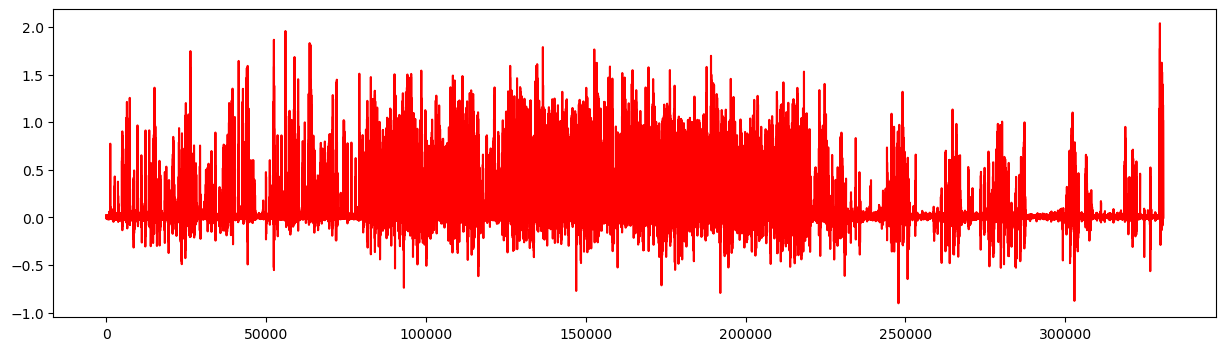

In [45]:
plt.figure(figsize=(15, 4))
#plt.plot(TEST_target, 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r-')
#plt.plot(Y_pred>0.5)

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
# ========== Training loop ========== #
L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        #N_aug = int(np.random.uniform(2, 14))
        N_aug = int(np.random.uniform(8, 14))
        #N_aug = int(np.random.uniform(15, 35))
        
        N_storm = 100 - N_aug
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):

            data = np.load(file_pick[k])
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.139665438997403
Validation loss improved from 0.14228168900012836 to 0.139665438997403
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 245.26410794258118 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.11155465839675104
Validation loss improved from 0.139665438997403 to 0.11155465839675104
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 258.13513827323914 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.11577001559402444
Validation loss 0.11577001559402444 NOT improved
0.10929269862122153
Validation loss improved from 0.11155465839675104 to 0.10929269862122153
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 264.859671831131 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.10405806509260838
Validation loss improved from 0.10929269862122153 to 0.10405806509260838
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 244.30402517318726 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.10205965099839594
Validation loss improved from 0.10405806509260838 to 0.10205965099839594
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 245.9176743030548 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.10097676413234137
Validation loss improved from 0.10205965099839594 to 0.10097676413234137
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 233.88730812072754 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.11074026481535794
Validation loss 0.11074026481535794 NOT improved
0.10700049559947428
Validation loss 0.10700049559947428 NOT improved
0.1096215600601216
Validation loss 0.1096215600601216 NOT improved
0.10675738289520233
Validation loss 0.10675738289520233 NOT improved
0.10334578343395066
Validation loss 0.10334578343395066 NOT improved
0.09749268736889395
Validation loss improved from 0.10097676413234137 to 0.09749268736889395
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 258.2676019668579 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.10123490913573195
Validation loss 0.10123490913573195 NOT improved
0.10938770787310198
Validation loss 0.10938770787310198 NOT improved
0.10534935415161788
Validation loss 0.10534935415161788 NOT improved
0.10319909538273431
Validation loss 0.10319909538273431 NOT improved
0.10434377580937097
Validation loss 0.10434377580937097 NOT improved
0.10119580374798366
Validation loss 0.10119580374798366 NOT improved
0.10531520198981714
Validation loss 0.10531520198981714 NOT improved
0.10693646617715262
Validation loss 0.10693646617715262 NOT improved
0.1046630316552433
Validation loss 0.1046630316552433 NOT improved
0.10764849509636853
Validation loss 0.10764849509636853 NOT improved
0.11154602886662178
Validation loss 0.11154602886662178 NOT improved
0.10860698908229041
Validation loss 0.10860698908229041 NOT improved
0.10948968465467004
Validation loss 0.10948968465467004 NOT improved
0.11203394775731466
Validation loss 0.11203394775731466 NOT improved
0.10927026726780699
Validation loss 

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x2ac3eb0bbdc0>
Traceback (most recent call last):
  File "/glade/work/ksha/anaconda3/lib/python3.9/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


0.1098157332771621
Validation loss 0.1098157332771621 NOT improved
0.10871517719060161
Validation loss 0.10871517719060161 NOT improved
0.10759717316081067
Validation loss 0.10759717316081067 NOT improved
0.10407280570782815
Validation loss 0.10407280570782815 NOT improved
0.1009412834032956
Validation loss 0.1009412834032956 NOT improved
0.09518490441712212
Validation loss improved from 0.09749268736889395 to 0.09518490441712212
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 240.40946578979492 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.09667354757215602
Validation loss 0.09667354757215602 NOT improved
0.09789993371674621
Validation loss 0.09789993371674621 NOT improved
0.09405344289746873
Validation loss improved from 0.09518490441712212 to 0.09405344289746873
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 232.7178294658661 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0949301591730776
Validation loss 0.0949301591730776 NOT improved
0.09296315196094658
Validation loss improved from 0.09405344289746873 to 0.09296315196094658
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 238.73059821128845 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.08582230813739819
Validation loss improved from 0.09296315196094658 to 0.08582230813739819
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 225.64713406562805 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.09436939290976458
Validation loss 0.09436939290976458 NOT improved
0.09616371893567278
Validation loss 0.09616371893567278 NOT improved
0.08779121670175467
Validation loss 0.08779121670175467 NOT improved
0.09348409565640624
Validation loss 0.09348409565640624 NOT improved
0.09564677394151556
Validation loss 0.09564677394151556 NOT improved
0.09834430512242359
Validation loss 0.09834430512242359 NOT improved
0.09944494047671062
Validation loss 0.09944494047671062 NOT improved
0.09543470157155391
Validation loss 0.09543470157155391 NOT improved
0.08850661892135112
Validation loss 0.08850661892135112 NOT improved
0.09721939536228018
Validation loss 0.09721939536228018 NOT improved
0.09404959160564831
Validation loss 0.09404959160564831 NOT improved
0.08980956162884822
Validation loss 0.08980956162884822 NOT improved
0.09191606686109428
Validation loss 0.09191606686109428 NOT improved
0.08980092396575338
Validation loss 0.08980092396575338 NOT improved
0.09263226423497319
Validation los

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0904350691949018
Validation loss 0.0904350691949018 NOT improved
0.08122660466101303
Validation loss improved from 0.08448025977724201 to 0.08122660466101303
save to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/FINAL_HALF_Lead21_pp23/assets
--- 239.22989749908447 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.08663364062157204
Validation loss 0.08663364062157204 NOT improved
0.08694812675268616
Validation loss 0.08694812675268616 NOT improved
0.08522873929736602
Validation loss 0.08522873929736602 NOT improved
0.0909517675618045
Validation loss 0.0909517675618045 NOT improved
0.08353549222178548
Validation loss 0.08353549222178548 NOT improved
0.09004812723860196
Validation loss 0.09004812723860196 NOT improved
0.08301723741265171
Validation loss 0.08301723741265171 NOT improved
0.08774790642380846
Validation loss 0.08774790642380846 NOT improved
0.08492707358315571
Validation loss 0.08492707358315571 NOT improved
0.09537816781417734
Validation loss 0.09537816781417734 NOT improved
0.1122741171213095
Validation loss 0.1122741171213095 NOT improved
0.08394457028201376
Validation loss 0.08394457028201376 NOT improved
0.10181429952268212
Validation loss 0.10181429952268212 NOT improved
0.09287752662561942
Validation loss 0.09287752662561942 NOT improved
0.0912090261832336
Validation loss 0.0

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.10137846574447769
Validation loss 0.10137846574447769 NOT improved
0.08876404495946526
Validation loss 0.08876404495946526 NOT improved
0.08535697139595282
Validation loss 0.08535697139595282 NOT improved
0.0858607056135904
Validation loss 0.0858607056135904 NOT improved
0.09172793941403555
Validation loss 0.09172793941403555 NOT improved
0.08279267614606609
Validation loss 0.08279267614606609 NOT improved
0.08911494593993233
Validation loss 0.08911494593993233 NOT improved
0.08341042364707227
Validation loss 0.08341042364707227 NOT improved
0.08967960242660433
Validation loss 0.08967960242660433 NOT improved
0.10469846201418588
Validation loss 0.10469846201418588 NOT improved
0.08735324140375729
Validation loss 0.08735324140375729 NOT improved
0.092103832555234
Validation loss 0.092103832555234 NOT improved
0.0915187706566786
Validation loss 0.0915187706566786 NOT improved
0.0867816776197886
Validation loss 0.0867816776197886 NOT improved
0.09517008773702179
Validation loss 0.095170


KeyboardInterrupt



In [38]:
j

123844

In [ ]:
https://mesonet.agron.iastate.edu/pickup/wwa/

In [29]:
10 % 3

1